# Agent Chat with Huggingface Models

## Set up the environment

In [1]:
%pip install huggingface_hub Pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import re

import PIL

import autogen
from autogen import AssistantAgent, GroupChat, GroupChatManager, UserProxyAgent
from autogen.agentchat.agent import Agent
from autogen.agentchat.contrib.huggingface_agent import HuggingFaceAgent
from autogen.agentchat.contrib.img_utils import get_pil_image

In [3]:
os.environ["HUGGINGFACE_API_KEY"] = "<YOUR_HF_TOKEN>"

In [4]:
config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={"model": "gpt-4"},
)

hf_config = {
    "api_key": os.environ.get("HUGGINGFACE_API_KEY"),
    "params": {
        "timeout": 60,
    },
}

## Helper Functions

Here is a helper function to extract image from the last message of a HuggingFaceAgent.

In [5]:
def extract_img(agent: Agent) -> PIL.Image:
    last_message = agent.last_message()["content"]

    if isinstance(last_message, str):
        img_data = re.findall("<img (.*)>", last_message)[0]
    elif isinstance(last_message, list):
        # The GPT-4V format, where the content is an array of data
        for item in last_message:
            if "image_url" in item:
                img_data = item["image_url"]["url"]
                break

    pil_img = get_pil_image(img_data)
    return pil_img

## Simple Example: Call directly from User

user_proxy (to multimodal_assistant):

Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION text-to-image...
multimodal_assistant (to user_proxy):

I generated an image with the prompt: happy robot on a black background showing a sign that reads 'I Love AutoGen'<image>

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': "Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'.", 'role': 'assistant'}, {'content': [{'type': 'text', 'text': "I generated an image with the prompt: happy robot on a black background showing a sign that reads 'I Love AutoGen'"}, {'type': 'image_url', 'image_url': {'url': ''}}], 'role': 'user'}], summary="I generated an image with the prompt: happy robot on a black background showing a sign that reads 'I Love AutoGen'", cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])
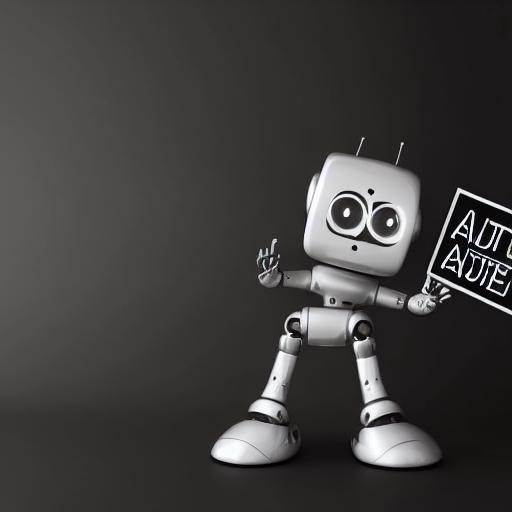

In [6]:
assistant = HuggingFaceAgent(
    name="multimodal_assistant",
    llm_config={"config_list": config_list},
    hf_config={"api_key": os.environ.get("HUGGINGFACE_API_KEY")},
)

user_proxy = UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    code_execution_config=False,
    default_auto_reply="",
    is_termination_msg=lambda x: True,
)

user_proxy.initiate_chat(
    assistant, message="Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'."
)

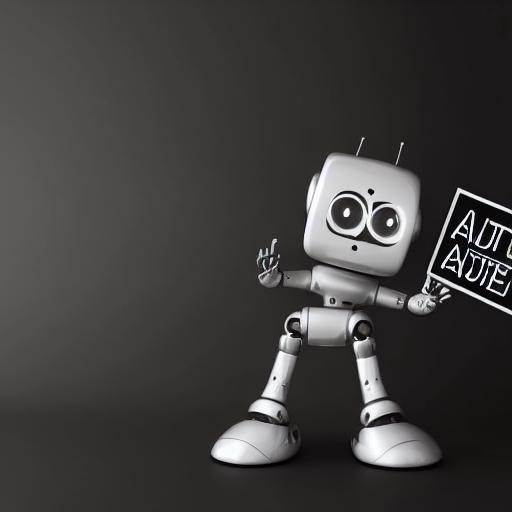

In [7]:
img = extract_img(assistant)

img.show()

## Example with Group Chat

In [8]:
user_proxy = UserProxyAgent(
    name="Admin",
    human_input_mode="NEVER",
    code_execution_config=False,
    default_auto_reply="TERMINATE",
    description="The human admin who gives the tasks.",
)

planner = AssistantAgent(
    name="Planner",
    system_message="Planner. Given a task, please determine what information is needed to complete the task.",
    llm_config={"config_list": config_list},
)

multimodal_assistant = HuggingFaceAgent(
    name="multimodal_assistant",
    llm_config={"config_list": config_list},
    hf_config={"api_key": os.environ.get("HUGGINGFACE_API_KEY")},
)

groupchat = GroupChat(
    agents=[user_proxy, planner, multimodal_assistant],
    messages=[],
    max_round=10,
)
manager = GroupChatManager(groupchat=groupchat, llm_config={"config_list": config_list})

user_proxy.initiate_chat(
    manager,
    message="""Write a poet for my image:
    <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""",
)

Admin (to chat_manager):

Write a poet for my image:
    <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION image-to-text...
multimodal_assistant (to chat_manager):

I generated the following text from the image: a small brown dog laying on the floor

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
multimodal_assistant (to chat_manager):

**Title: A Moment in Repose**

In a quiet nook where shadows dance,  
On the cool embrace of the floor's expanse,  
Lies a small brown dog, in tranquil state,  
A portrait of peace, simply innate.

No worries to wear, nor cares to carry,  
In dreams, perhaps, through fields they tarry,  
Chasing the breeze, under the sun’s warm glow,  
Or amidst autumn leaves, in gentle flow.

Their fur, a tapestry 

ChatResult(chat_id=None, chat_history=[{'content': 'Write a poet for my image:\n    <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.', 'role': 'assistant'}, {'content': 'I generated the following text from the image: a small brown dog laying on the floor', 'name': 'multimodal_assistant', 'role': 'user'}, {'content': "**Title: A Moment in Repose**\n\nIn a quiet nook where shadows dance,  \nOn the cool embrace of the floor's expanse,  \nLies a small brown dog, in tranquil state,  \nA portrait of peace, simply innate.\n\nNo worries to wear, nor cares to carry,  \nIn dreams, perhaps, through fields they tarry,  \nChasing the breeze, under the sun’s warm glow,  \nOr amidst autumn leaves, in gentle flow.\n\nTheir fur, a tapestry of earth-toned hues,  \nReflects a life, simple and true.  \nEach breath they take, a soft whisper in time,  \nA gentle reminder of the divine.\n\nIn this silent space, the world seems right,  \nA furry friend, i